In [1]:
import os
import re
import json
import base64
import pickle
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from glob import glob
from PIL import Image
from utils.images_paths import *
from utils.independents_poisson_model import IndependentsPoissonModel

In [2]:
total = 0
without_hess = 0
didnt_converge = 0
wrong_number_of_parameters = 0
for file in glob('results/optimizer/*'):
    total += 1
    pars = int(re.findall('_(\d+)_pars', file)[0])
    with open(file, 'rb') as f:
        res = pickle.load(f)

    without_hess += res.hess_inv is None
    didnt_converge += not res.success
    wrong_number_of_parameters += res.x.shape[0] != pars - 1

if without_hess: print(f'{without_hess} / {total} ({without_hess / total:.2%}) of results don\'t have hessian')
if didnt_converge: print(f'{didnt_converge} / {total} ({didnt_converge / total:.2%}) of results didn\'t converge')
if wrong_number_of_parameters: print(f'{wrong_number_of_parameters} / {total} ({wrong_number_of_parameters / total:.2%}) of results has a wrong number of parameters')

In [3]:
historic = pd.DataFrame(columns = ['competition', 'year', 'games', 'home_historic', 'draw_historic', 'away_historic'])
for competition in ['Serie_A', 'Serie_B']:
    for year in range(2013, 2024):
        with open(f'../data/BrazilianSoccerData/results/processed/{competition}_{year}_games.json', 'r') as f: data = json.load(f)
        for rd in range(1, 39):
            if competition == 'Serie_A' and year == 2023 and rd >= 22: continue
            elif competition == 'Serie_B' and year == 2023 and rd >= 27: continue

            home = 0
            draw = 0
            away = 0
            for game in range(rd * 10 + 1, rd * 10 + 11):
                game = f'{game}'.zfill(3)
                if game not in data or 'Home' not in data[game]: continue
                result = data[game]['Result'].upper().split(' X ')
                result[0], result[1] = int(result[0]), int(result[1])
                if result[0] > result[1]: home += 1
                elif result[0] == result[1]: draw += 1
                else: away += 1
            
            historic.loc[len(historic)] = [competition, year, rd * 10, home, draw, away]

historic['total'] = historic['home_historic'] + historic['draw_historic'] + historic['away_historic']
for result in ['total', 'home_historic', 'draw_historic', 'away_historic']:
    historic[result] = historic.groupby('competition')[result].cumsum()
    if result == 'total': continue
    historic[result] = historic[result] / historic['total']

historic

,competition,year,games,home_historic,draw_historic,away_historic,total
0,Serie_A,2013,10,0.500000,0.300000,0.200000,10
1,Serie_A,2013,20,0.450000,0.400000,0.150000,20
2,Serie_A,2013,30,0.500000,0.300000,0.200000,30
3,Serie_A,2013,40,0.475000,0.325000,0.200000,40
4,Serie_A,2013,50,0.460000,0.320000,0.220000,50
...,...,...,...,...,...,...,...
802,Serie_B,2023,220,0.469117,0.284584,0.246299,3918
803,Serie_B,2023,230,0.469196,0.284369,0.246436,3928
804,Serie_B,2023,240,0.468766,0.284916,0.246318,3938
805,Serie_B,2023,250,0.468338,0.285461,0.246201,3948


In [4]:
df_results = pd.DataFrame(columns = ['competition', 'year', 'model', 'fitted_games', 'pars',
                                     'home', 'away', 'result', 'deFinetti', 'prob_home', 'prob_draw', 'prob_away'])

for file in glob('results/probs/game_probs*'):
    competition, year, model, games, pars = re.findall('game_probs_(Serie_[AB])_(\d+)_(.+)_(\d+)_games_(\d+)_pars', file)[0]
    games = int(games)
    if games == 380: continue
    with open(file, 'r') as f: probs = json.load(f)
    with open(f'../data/BrazilianSoccerData/results/processed/{competition}_{year}_games.json', 'r') as f: data = json.load(f)
    year = int(year)
    pars = int(pars)
    for game in range(games + 1, games + 11):
        game = f'{game}'
        if game not in data or 'Home' not in data[game]: continue
        home = data[game]['Home']
        away = data[game]['Away']
        result = data[game]['Result'].upper().split(' X ')
        result[0], result[1] = int(result[0]), int(result[1])
        if result[0] > result[1]: result, result_vector = 'H', np.array([1, 0, 0])
        elif result[0] == result[1]: result, result_vector = 'D', np.array([0, 1, 0])
        else: result, result_vector = 'A', np.array([0, 0, 1])
        prob_home = np.sum(np.tril(probs[home][away], -1))
        prob_draw = np.sum(np.diag(probs[home][away]))
        prob_away = np.sum(np.triu(probs[home][away], 1))
        probs_vector = np.array([prob_home, prob_draw, prob_away])
        definetti = np.sum((probs_vector - result_vector) ** 2)
        prob_result = probs_vector[np.argmax(result_vector)]
        df_results.loc[len(df_results)] = competition, year, model, games, pars, home, away, result, definetti, prob_home, prob_draw, prob_away

df_results = df_results.merge(historic, left_on = ['competition', 'year', 'fitted_games'], right_on = ['competition', 'year', 'games'])
df_confiability = pd.DataFrame()
df_results['deFinetti_prop_naive'] = 0
for result in ['home', 'draw', 'away']:
    df_results[f'prob_{result}_arred'] = np.abs(np.ceil(df_results[f'prob_{result}'] * 10) / 10 - .05)
    df_results[f'{result}_occured'] = (df_results['result'] == result[0].upper()) * 1
    df_results['deFinetti_prop_naive'] += (df_results[f'{result}_historic'] - df_results[f'{result}_occured']) ** 2
    aux = df_results[[f'prob_{result}_arred', f'{result}_occured']]
    aux.columns = ['prob', 'occured']
    df_confiability = pd.concat([df_confiability, aux], ignore_index=True)

df_confiability = df_confiability.groupby('prob').mean().reset_index()
definetti_metric = df_results[['model', 'deFinetti', 'pars']].groupby(['model', 'pars']).mean().reset_index()
definetti_metric.loc[len(definetti_metric)] = ['naive baseline', '0', np.sum((1/3 * np.ones(3) - result_vector) ** 2)]
definetti_metric.loc[len(definetti_metric)] = ['historic baseline', '0', np.mean(df_results['deFinetti_prop_naive'])]
definetti_metric = definetti_metric.sort_values('deFinetti', ignore_index=True)

In [5]:
definetti_metric

,model,pars,deFinetti
0,independents_poisson,41,0.626142
1,shock_model,61,0.627103
2,historic baseline,0,0.633874
3,independents_poisson,60,0.634388
4,shock_model,80,0.636446
5,holgates_poisson,61,0.643419
6,independents_poisson,80,0.649255
7,holgates_poisson,80,0.652162
8,shock_model,100,0.654546
9,independents_poisson,40,0.656078


In [6]:
df_confiability

,prob,occured
0,0.05,0.183076
1,0.15,0.229161
2,0.25,0.280389
3,0.35,0.330638
4,0.45,0.403229
5,0.55,0.483016
6,0.65,0.546198
7,0.75,0.587205
8,0.85,0.591968
9,0.95,0.632184


## Confidence intervals

In [7]:
def get_ci(res, inx, home_away_pars, clip):
    variances = np.diag(np.linalg.inv(res.hess_inv @ np.eye(40 + home_away_pars - 1)))
    lower_bound, upper_bound = np.clip(res.x - 1.96 * variances, 0, None), res.x + 1.96 * variances
    lower_bound, upper_bound = res.x - 1.96 * variances, res.x + 1.96 * variances
    if clip: lower_bound = np.clip(lower_bound, 0, None)
    confidence_intervals = dict()
    for club in inx:
        confidence_intervals[club] = dict()
        for force in inx[club]:
            if inx[club][force] == 0: confidence_intervals[club][force] = [1, 1, 1]
            else: confidence_intervals[club][force] = [lower_bound[inx[club][force] - 1], res.x[inx[club][force] - 1], upper_bound[inx[club][force] - 1]]

    confidence_intervals = dict(sorted(confidence_intervals.items()))
    confidence_intervals = {
        'Flamengo / RJ': confidence_intervals['Flamengo / RJ'],
        **{chave: valor for chave, valor in confidence_intervals.items() if chave != 'Flamengo / RJ'}
    }

    return confidence_intervals

In [8]:
def plot_ci(confidence_intervals, force, clip, to_git = False):
    clubs = list(confidence_intervals.keys())
    center_values = [data[force][1] for data in confidence_intervals.values()]
    lim_inf = [data[force][0] for data in confidence_intervals.values()]
    lim_sup = [data[force][2] for data in confidence_intervals.values()]
    fig = go.Figure()
    fig_size = 1.5 * max(lim_sup) / 10
    for i in range(len(clubs)):
        club = clubs[i]
        center_value = center_values[i]
        inf = lim_inf[i]
        sup = lim_sup[i]

        fig.add_trace(go.Scatter(
            x=[club, club],
            y=[inf, sup],
            mode='lines',
            line=dict(color='blue'),
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=[club],
            y=[center_value],
            mode='markers',
            marker=dict(
                symbol='circle',
                size=10,
                color='blue',
                line=dict(
                    width=2,
                    color='black'
                )
            ),
            showlegend=False
        ))

        img_path = os.path.join('..', 'Images', img_files.get(club.replace(' ', '').replace('Mineiro', ''), ''))
        try: logo = base64.b64encode(open(img_path, 'rb').read())
        except: print(club)
        fig.add_layout_image(
            source='data:image/png;base64,{}'.format(logo.decode()),
            xref='x',
            yref='y',
            x=i,
            y=sup + fig_size / 2 + .5,
            xanchor='center',
            yanchor='bottom',
            sizex=fig_size,
            sizey=fig_size,
        )

    fig.update_layout(
        xaxis=dict(range=[-1, len(confidence_intervals)]),
        yaxis=dict(range=[min(lim_inf) - fig_size / 6, max(lim_sup) + 2 * fig_size]),
        title=f'Confidence interval - {force.lower()} parameters' + (' - truncated' if clip else ''),
        yaxis_title='Parameter',
        width=1200,
        height=800
    )

    if to_git: fig.show('png')
    else: fig.show()

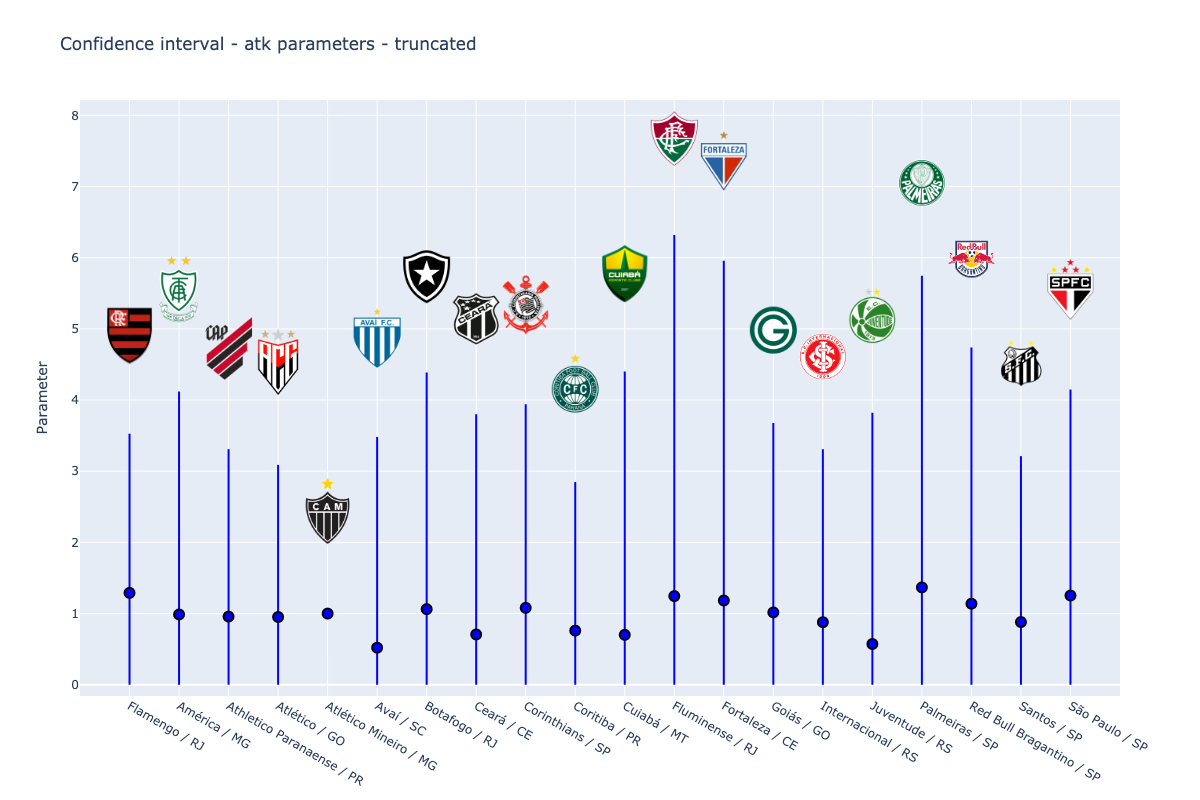

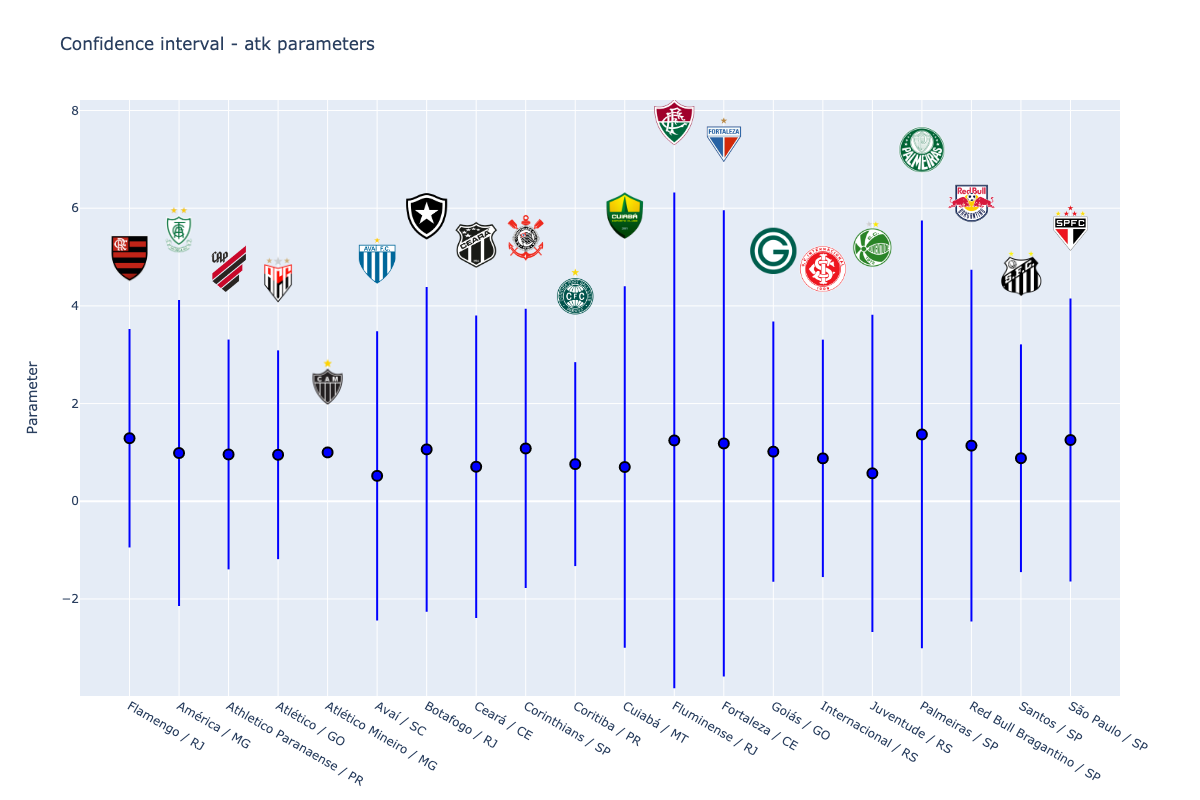

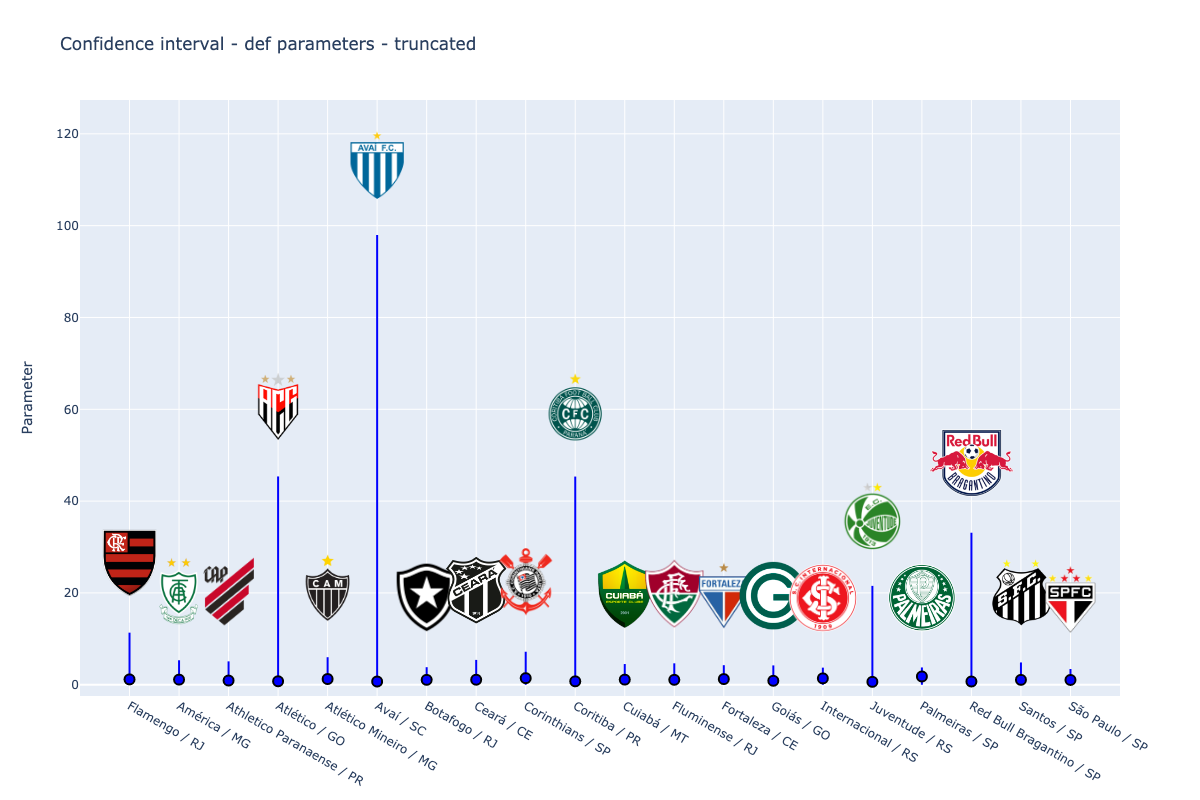

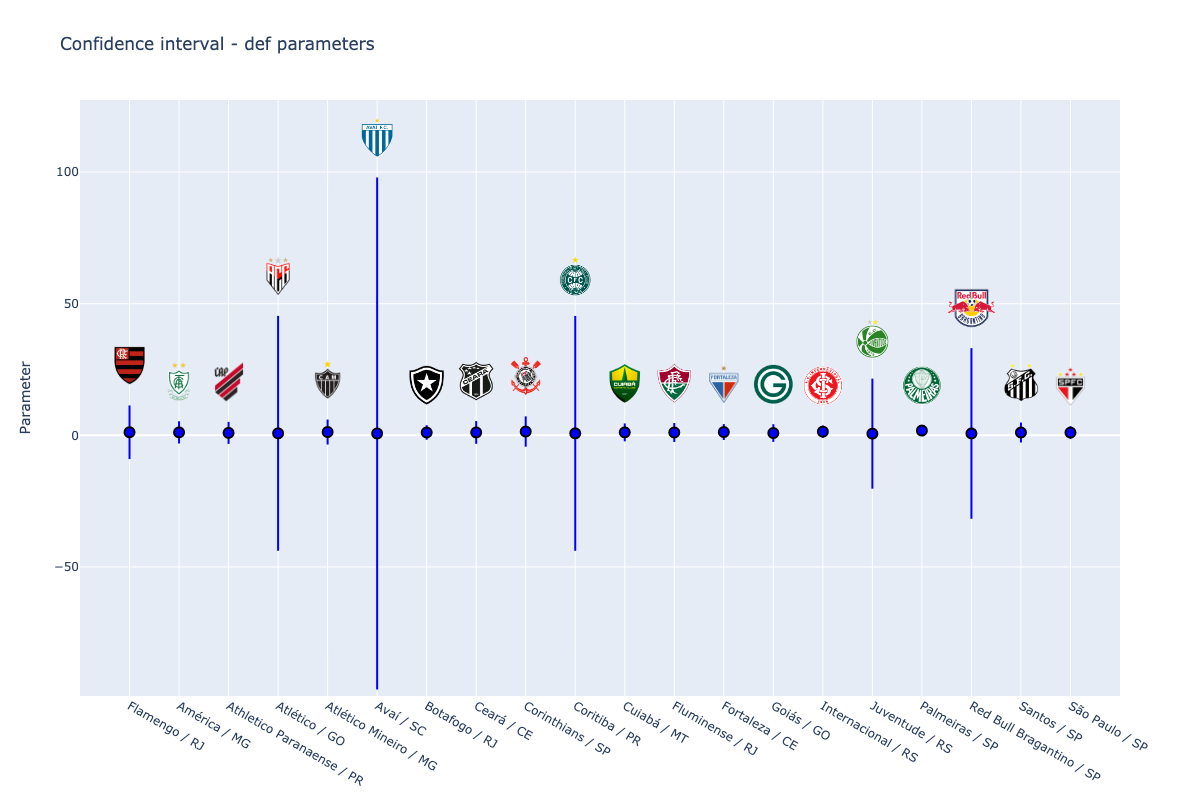

In [9]:
competition, year, home_away_pars, clip = 'Serie_A', 2022, 20, True
with open(f'results/optimizer/optimizer_result_{competition}_{year}_independents_poisson_380_games_{40 + home_away_pars}_pars.pkl', 'rb') as f:
    res = pickle.load(f)

_, inx, _, _ = IndependentsPoissonModel(competition, year, home_away_pars = home_away_pars).preprocessing()

for force in ['Atk', 'Def']:
    for clip in [True, False]:
        confidence_intervals = get_ci(res, inx, home_away_pars, clip)
        plot_ci(confidence_intervals, force, clip, True)

In [10]:
# df_results[df_results['prob_away_arred'] == 0]

# with open('results/probs/game_probs_Serie_B_2015_shock_model_330_games_100_pars.json', 'r') as f: data = json.load(f)
# with open('parameters/Serie_B_2015_shock_model_330_games_100_pars.json', 'r') as f: pars = json.load(f)
# data['Náutico / PE']['Paraná / PR'], pars['Náutico / PE'], pars['Paraná / PR']

# with open('results/probs/game_probs_Serie_A_2021_holgates_poisson_250_games_100_pars.json', 'r') as f: data = json.load(f)
# with open('parameters/Serie_A_2021_holgates_poisson_250_games_100_pars.json', 'r') as f: pars = json.load(f)
# data['Chapecoense / SC']['Athletico Paranaense / PR'], pars['Chapecoense / SC'], pars['Athletico Paranaense / PR']

In [11]:
confidence_intervals

{'Flamengo / RJ': {'Atk': [-0.9459945980405837,
   1.2907009176423176,
   3.527396433325219],
  'Def': [-9.016691459728735, 1.1658950434523465, 11.348481546633428],
  'Home bonus': [-1.6184800323987245, 0.5246558010297783, 2.667791634458281]},
 'América / MG': {'Atk': [-2.1434131342420004,
   0.9876178144003722,
   4.118648763042745],
  'Def': [-3.1014449412812275, 1.1157470661499889, 5.332939073581205],
  'Home bonus': [-2.62511222641146, 0.09437744381961193, 2.8138671140506837]},
 'Athletico Paranaense / PR': {'Atk': [-1.3945620759017274,
   0.9580562235972996,
   3.310674523096327],
  'Def': [-3.2618334172016072, 0.917591374976229, 5.097016167154065],
  'Home bonus': [-1.419295747244228, 0.5951383828589829, 2.6095725129621936]},
 'Atlético / GO': {'Atk': [-1.1855087031417213,
   0.9518776304466502,
   3.0892639640350215],
  'Def': [-43.85958718527437, 0.7571135271282056, 45.37381423953078],
  'Home bonus': [-2.4965621866514636,
   0.15704420111155934,
   2.8106505888745823]},
 'Atlé